In [1]:
import micromagneticmodel as mm
import discretisedfield as df
import oommfc as oc
import matplotlib.pyplot as plt
import numpy as np
import micromagneticdata as md
%matplotlib inline

In [5]:
oc.runner.runner = oc.oommf.DockerOOMMFRunner()

Running OOMMF (DockerOOMMFRunner)[2022/03/29 12:20]... (4.1 s)
OOMMF found and running.


In [2]:
class System():
    def __init__(self,l,l2,w):
        region=df.Region(p1=(-l,-w,0),p2=(l2,w,3e-9))
        subregions={'bottom':df.Region(p1=(-l,-w,0),p2=(l2,w,1e-9)),
                    'spacer':df.Region(p1=(-l,-w,1e-9),p2=(l2,w,2e-9)),
                    'top':df.Region(p1=(-l,-w,2e-9),p2=(l2,w,3e-9))}
        cell=(2e-9,2e-9,1e-9)
        mesh=df.Mesh(region=region,cell=cell,subregions=subregions)
        self.mesh = mesh
    def mate_paras(self,L,K_uv,ms=0.58e6,a=15e-12,d=3.5e-3,k=0.8e6):
        self.ms = ms
        self.a = a
        self.d = d
        self.k = k
        def K_fun(pos):
            x,y,z=pos
            if 0 <= x <= L:
                return self.k + (K_uv-self.k) * x / L
            else :
                return self.k
        Ms = {'bottom':self.ms,'spacer':0,'top':self.ms}
        A = {'bottom':self.a,'spacer':0,'top':self.a}
        D = {'bottom':self.d,'spacer':0,'top':self.d}
        K = df.Field(self.mesh,dim=1,value=K_fun)
        self.Ms = Ms
        self.A = A
        self.D = D
        self.K = K
    def initial(self):
        def m_init(pos):
            x,y,z=pos
            if 0 <= z < 1e-9:
                if ((x+120e-9)**2+y**2)**0.5 <= 8e-9:
                    return (0,0,-1)
                elif ((x+80e-9)**2+y**2)**0.5 <= 8e-9:
                    return (0,0,-1)
                elif ((x+100e-9)**2+(y-20e-9)**2)**0.5 <= 8e-9:
                    return (0,0,-1)
                elif ((x+100e-9)**2+(y+20e-9)**2)**0.5 <= 8e-9:
                    return (0,0,-1)
                elif ((x+100e-9)**2+y**2)**0.5 <= 70e-9:
                    return (0,0,1)
                else :
                    return (0,0,-1)
            else:
                if ((x+120e-9)**2+y**2)**0.5 <= 8e-9:
                    return (0,0,1)
                elif ((x+80e-9)**2+y**2)**0.5 <= 8e-9:
                    return (0,0,1)
                elif ((x+100e-9)**2+(y-20e-9)**2)**0.5 <= 8e-9:
                    return (0,0,1)
                elif ((x+100e-9)**2+(y+20e-9)**2)**0.5 <= 8e-9:
                    return (0,0,1)
                elif ((x+100e-9)**2+y**2)**0.5 <= 70e-9:
                    return (0,0,-1)
                else :
                    return (0,0,1)
        self.m_init = m_init
    def sys(self):
        system=mm.System(name='skg2')
        system.energy=mm.Exchange(A=self.A)+mm.UniaxialAnisotropy(K=self.K,u=(0,0,1))\
                     +mm.Demag()+mm.DMI(D=self.D,crystalclass='Cnv_z')\
                     +mm.RKKY(sigma=-2e-3,sigma2=0,subregions=['bottom','top'])
        system.dynamics=mm.Precession(gamma0=2.211e5)+mm.Damping(alpha=0.3)
        system.m=df.Field(mesh=self.mesh,dim=3,value=self.m_init,norm=self.Ms)
        docker_runner = oc.oommf.DockerOOMMFRunner()
        self.system = system
        self.runner = docker_runner
        self.dynamics = system.dynamics
        self.m = system.m
    def relax(self,t=4e-10,n=10):
        td=oc.TimeDriver()
        td.drive(self.system,runner=self.runner,t=t,n=n)
    def drive(self,u,t=1e-9,n=100):
        td=oc.TimeDriver()
        self.system.dynamics = self.dynamics + mm.ZhangLi(u=u,beta=0.4)
        td.drive(self.system,runner=self.runner,t=t,n=n)
    def tu(self,i=-1,j=-1,k=-1):
        with plt.style.context(['notebook','dark_background']):
            data = md.Data(name='skg2')
            data[i][j].orientation.z.plane(z=0).mpl()
            data[k].table.mpl(figsize=(10,10),y=['E'],marker='o')

In [3]:
S = System(l=300e-9,w=100e-9,l2=300e-9)
S.mate_paras(L=50e-9,K_uv=1.12e6)
S.initial()
S.sys()
S.relax()
S.drive(u=200,t=1.8)

Running OOMMF (DockerOOMMFRunner)[2022/04/28 20:31]... (1070.8 s)
Running OOMMF (DockerOOMMFRunner)[2022/04/28 20:49]... 

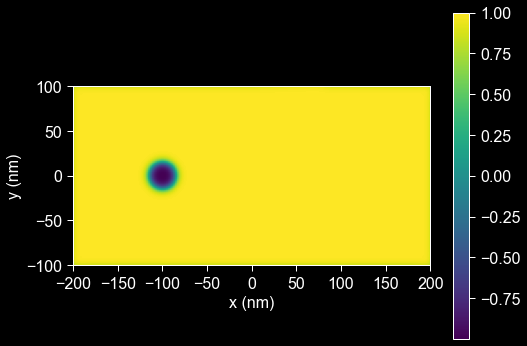

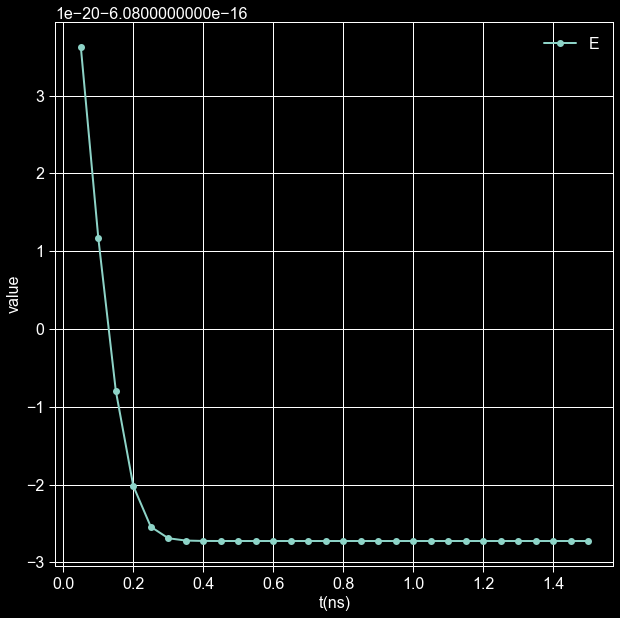

In [10]:
S.tu(i=-1, j=-1,k=-1)

In [15]:
mm.consts.e * 0.58e6 * 2 / (mm.consts.gamma * mm.consts.hbar * 0.4 * 1e10)

2.5021163117705307

In [20]:
#整个平面的能量密度
density = oc.compute(S.system.energy.density,S.system)

Running OOMMF (DockerOOMMFRunner)[2022/03/29 13:14]... (18.2 s)


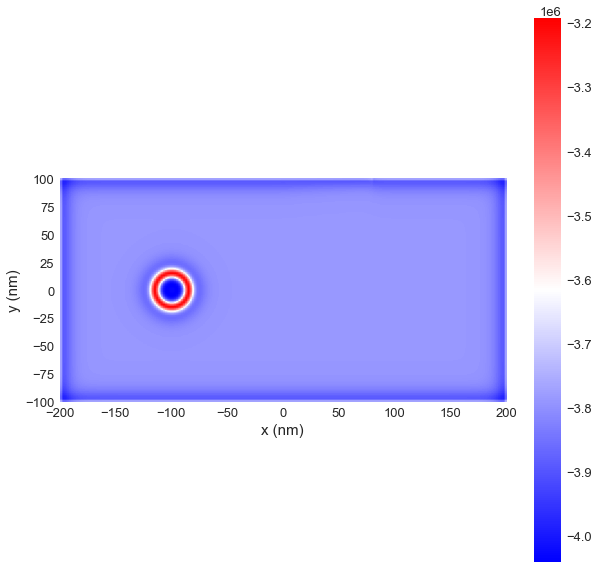

In [52]:
density.plane(z=0).mpl.scalar(figsize=(10,10),cmap='bwr')

In [45]:
#第一层和第三层的能量密度
den2 = density.value[:,:,[0,2],:]

In [102]:
#斯格明子的半径
data = md.Data(name='skg2')
vz = data[-1][-1].line(p1=(-200e-9,0,0),p2=(200e-9,0,0),n=200).data['vz']
line0 = [0]*200
x = data[-1][-1].orientation.line(p1=(-200e-9,0,0),p2=(200e-9,0,0),n=200).data['px']*1e9
arg = np.argwhere(np.diff(np.sign(vz-line0))).flatten()
a = list(x[arg])
arg[0],arg[1]

(42, 56)

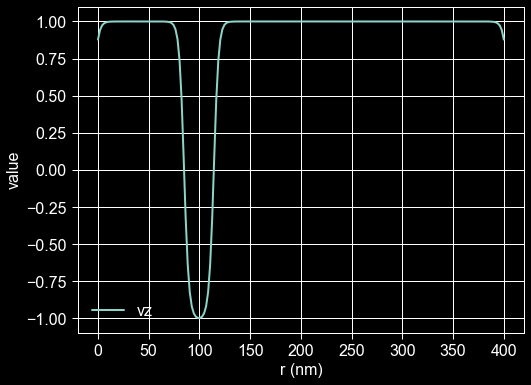

In [98]:
with plt.style.context(['notebook','dark_background']):
    data[-1][-1].orientation.line(p1=(-200e-9,0,0),p2=(200e-9,0,0),n=200).mpl(yaxis=['vz'])

In [106]:
#计算斯格明子能量
l1 = -200e-9
l2 = 200e-9
w1 = -100e-9
w2 = 100e-9
n = 2e-9
def suoyouge_func(x,y):
    x0 = (arg[0]+arg[1])/2
    y0 = 50 #圆心
    r0 = (arg[1]-arg[0])/2 #半径（单元格数量）
    if (x-x0)**2 + (y-y0)**2 <= r0**2:
        return density.value[x,y,0,0]
    else:
        return None
X = range(0,200)
Y = range(0,200)
satisfy = []
for i in X:
    for j in Y:
        a = suoyouge_func(i,j)
        if a != None:
            satisfy.append(a)
sum(satisfy) * len(satisfy) * n * n * 1e-9

-3.343906574428501e-16

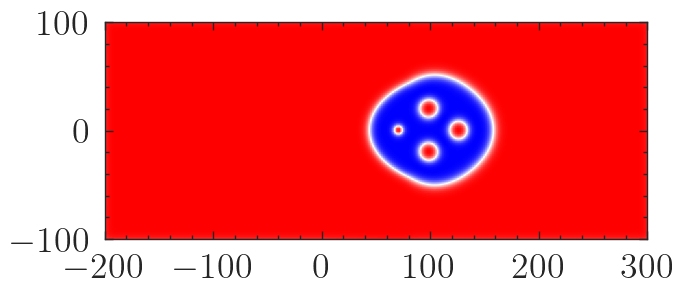

In [25]:
data = md.Data(name='skg2')
with plt.style.context(['seaborn-white','science']):
    fig, ax = plt.subplots(dpi=200)
    data[-1][84].orientation.z.plane(z=3e-9).mpl.scalar(ax=ax,cmap='bwr',colorbar=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.savefig('f:/tupian/moban')
    plt.show()

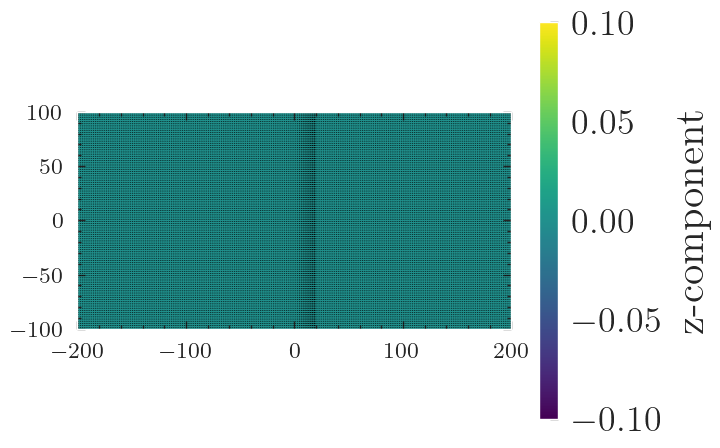

In [14]:
ua = df.Field.fromfile('f:/温度/skg2/drive-186/uniaxialanisotropy_K.ovf')
with plt.style.context(['science']):
    fig, ax = plt.subplots(dpi=200)
    ua.plane(z=0).mpl(ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.tick_params(labelsize=8)
    plt.show()

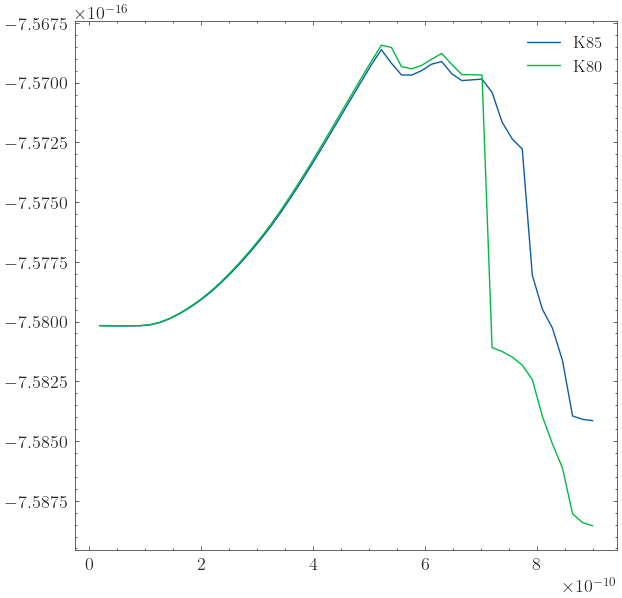

In [51]:
E1 = data[-1].table.data['E']
t1 = data[-1].table.data['t']
E2 = data[-3].table.data['E']
with plt.style.context(['seaborn-white','science']):
    fig,ax = plt.subplots(figsize=(7,7),dpi=100)
    ax.plot(t1,E1,label='K85')
    ax.plot(t1,E2,label='K80')
    plt.legend()
    plt.show()

In [13]:
def func(x, y):
    return x + y
f = func(2, 3)
func.__code__.co_varnames

('x', 'y')

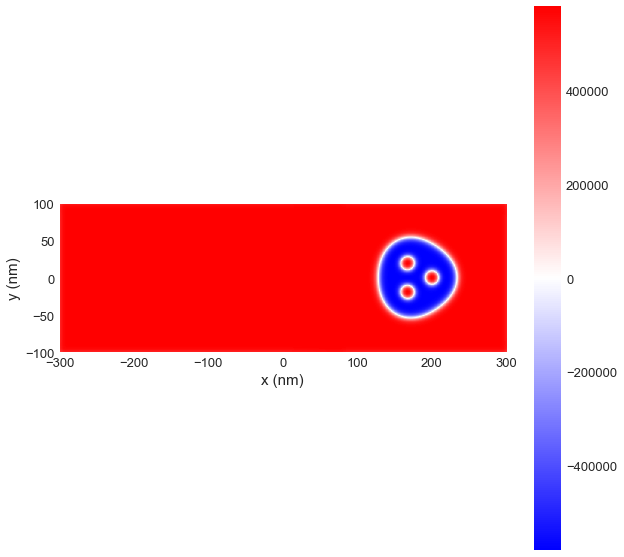

In [97]:
data[-1][-1].z.plane(z=3e-9).mpl.scalar(figsize=(10,10),cmap='bwr',
                                     filter_field=data[-1][-1].z)

In [108]:
field = df.Field.fromfile('f:/温度/skg2/compute-0/skg2_longgekuta.oef')

In [111]:
field.write('f:/温度/zhuan.hdf5')